In [2]:
# Step 1: Load IMDb Dataset
from datasets import load_dataset

# Load IMDb data
imdb = load_dataset("imdb")
train = imdb["train"].to_pandas()
test = imdb["test"].to_pandas()

# Extract text and labels
text_X_train = train["text"]
y_train = train["label"]
text_X_test = test["text"]
y_test = test["label"]

# Display dataset distribution
print(f"Training data size: {len(text_X_train)}")
print(f"Test data size: {len(text_X_test)}")
print(f"Proportion of positive reviews: {round((y_train.mean()) * 100, 2)}%")


Training data size: 25000
Test data size: 25000
Proportion of positive reviews: 50.0%


In [3]:
# The dataset is already split into training and test sets
# text_X_train and text_X_test are extracted directly from the IMDb dataset
# y_train and y_test contain the corresponding labels

# Display the first few samples from the training set
print("Sample training data:")
print(text_X_train.head())

print("\nSample training labels:")
print(y_train.head())

# Verify the shape of the datasets
print(f"\nTraining set size: {text_X_train.shape[0]}")
print(f"Test set size: {text_X_test.shape[0]}")


Sample training data:
0    I rented I AM CURIOUS-YELLOW from my video sto...
1    "I Am Curious: Yellow" is a risible and preten...
2    If only to avoid making this type of film in t...
3    This film was probably inspired by Godard's Ma...
4    Oh, brother...after hearing about this ridicul...
Name: text, dtype: object

Sample training labels:
0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

Training set size: 25000
Test set size: 25000


In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load a model and tokenizer more suitable for general sentiment analysis (e.g., IMDb)
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
transformer_model = AutoModelForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment"
)

# Keep device logic unchanged
device = "cuda:0" if torch.cuda.is_available() else "cpu"


In [5]:
# Step 3: Convert Text to Tensor Representations
import numpy as np
import tqdm

def text_to_tensor(
    list_text: list,
    transformer_model: AutoModelForSequenceClassification,
    tokenizer: AutoTokenizer,
    device: str,
) -> np.ndarray:
    tokenized_text = [
        tokenizer.encode(text, return_tensors="pt", truncation=True, padding=True)
        for text in list_text
    ]
    transformer_model = transformer_model.to(device)
    representations = []
    
    for tokens in tqdm.tqdm(tokenized_text):
        # Get the last hidden state and average over tokens
        with torch.no_grad():
            output = transformer_model(tokens.to(device), output_hidden_states=True)
            hidden_states = output.hidden_states[-1].mean(dim=1).cpu().numpy()
        representations.append(hidden_states)
    
    return np.concatenate(representations, axis=0)

# Vectorize training and test data
X_train_transformer = text_to_tensor(text_X_train.tolist(), transformer_model, tokenizer, device)
X_test_transformer = text_to_tensor(text_X_test.tolist(), transformer_model, tokenizer, device)


100%|█████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:59<00:00, 83.41it/s]


In [6]:
# Step 4: Train XGBoost Model
from concrete.ml.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define XGBoost classifier
model = XGBClassifier()

# Grid search for hyperparameter tuning
parameters = {
    "n_bits": [2, 3],
    "max_depth": [1],
    "n_estimators": [10, 30, 50],
    "n_jobs": [-1],
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=1, scoring="accuracy")
grid_search.fit(X_train_transformer, y_train)

# Best model and score
best_model = grid_search.best_estimator_
print(f"Best accuracy during grid search: {grid_search.best_score_:.4f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Best accuracy during grid search: 0.8944


In [13]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     12500
           1       0.89      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



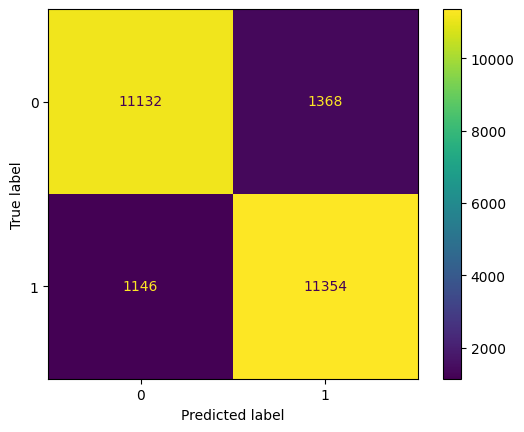

In [7]:
# Step 5: Evaluate Model
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

# Predictions
y_pred = best_model.predict(X_test_transformer)

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()


In [8]:
import time
import numpy as np

# Compile the model for FHE
start = time.perf_counter()
best_model.compile(X_train_transformer)
end = time.perf_counter()
print(f"Compilation time: {end - start:.2f} seconds")

# Randomly select 10 examples from the test set
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(len(text_X_test), size=10, replace=False)
random_reviews = [text_X_test[i] for i in random_indices]

# Convert the selected reviews to tensor representations
X_tested_reviews = text_to_tensor(random_reviews, transformer_model, tokenizer, device)

# Predictions using the clear model (for comparison)
clear_proba = best_model.predict_proba(X_tested_reviews)
print("Probabilities from the clear model:")
for i, review in enumerate(random_reviews):
    print(f"Review {i+1}: {review}")
    for idx, prob in enumerate(clear_proba[i]):
        print(f"  Class {idx}: {prob:.4f}")

# Predictions using FHE (measure inference time)
fhe_times = []
for i, review_tensor in enumerate(X_tested_reviews):
    start = time.perf_counter()
    fhe_proba = best_model.predict_proba(review_tensor.reshape(1, -1), fhe="execute")
    end = time.perf_counter()
    fhe_time = end - start
    fhe_times.append(fhe_time)
    print(f"\nFHE inference for Review {i+1}:")
    print(f"  Time: {fhe_time:.4f} seconds")
    for idx, prob in enumerate(fhe_proba[0]):
        print(f"  Class {idx}: {prob:.4f}")

# Calculate average FHE inference time
average_fhe_time = np.mean(fhe_times)
print(f"\nAverage FHE inference time over 10 examples: {average_fhe_time:.4f} seconds")

Compilation time: 10.33 seconds


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.04it/s]


Probabilities from the clear model:
Review 1: I could not believe how terrible and boring this Hollywood remake was.It's so dreadful. It easily lands a place in my top 10 worst films of 1998.About the only thing it had going for it was Bruce Willis,who should stick to action films,as a completely emotionless killer who'd kill his own mother for the right price.But I'd rather listen to Robbie Coltraine talk American for a week than listen to Richard Gere's nauseating Irish accent again.But this film is also implausible,unconvincing,uneven,unexciting,unimpressive and lands Sidney Poiter in a rubbish role to make a possible career comeback.One for filmroll-footie purposes entirely.
  Class 0: 0.9641
  Class 1: 0.0359
Review 2: I rented Boogie Nights last week and I could tell you, when I watched the film I had a blast. If you think that when you watch the film you will get sicked by the porn. I mean yes, if your not a porn person who can't bother being by it, than this isn't the film to s

In [28]:
# Let's save the model to be pushed to a server later
from concrete.ml.deployment import FHEModelDev
fhe_api = FHEModelDev("sentiment_fhe_model", best_model)
fhe_api.save()


In [12]:
from sklearn.metrics import accuracy_score
import numpy as np

# Use a small subset for quick evaluation with random sampling
num_samples = min(5000, len(X_test_transformer))  # Limit to 100 samples or less if smaller dataset
indices = np.random.choice(len(y_test), num_samples, replace=False)
y_true_subset = y_test[indices]
X_test_subset = X_test_transformer[indices]

# Clear model predictions
y_pred_clear = best_model.predict(X_test_subset)
clear_acc = accuracy_score(y_true_subset, y_pred_clear)
print(f"Evaluating on {num_samples} randomly selected samples out of {len(y_test)} available.")
print(f"Clear Model Predictions: {set(y_pred_clear)}")
print(f"True Labels: {set(y_true_subset)}")
print(f"Clear Model Accuracy: {clear_acc:.4f}")

# FHE model predictions
y_pred_fhe = best_model.predict(X_test_subset, fhe="execute")
fhe_acc = accuracy_score(y_true_subset, y_pred_fhe)
print(f"FHE Model Predictions: {set(y_pred_fhe)}")
print(f"FHE Model Accuracy: {fhe_acc:.4f}")

# Check mismatches
total_mismatches = np.sum(y_pred_clear != y_pred_fhe)
print(f"Total mismatches between Clear and FHE predictions: {total_mismatches}")


Evaluating on 5000 randomly selected samples out of 25000 available.
Clear Model Predictions: {0, 1}
True Labels: {0, 1}
Clear Model Accuracy: 0.9016
FHE Model Predictions: {0, 1}
FHE Model Accuracy: 0.9016
Total mismatches between Clear and FHE predictions: 0
